In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# Message Passing Interface (MPI)

The [Message Passing Interface (MPI)](https://en.wikipedia.org/wiki/Message_Passing_Interface) system can be used to parallelize the evaluation of many (almost all) the functions available in the TransportMaps package. This can be done on [standalone configurations](#Standalone-MPI) as well as on [shared clusters](#MPI-on-shared-clusters).

The following functionalities require the python packages [mpi4py](https://pypi.python.org/pypi/mpi4py) and [mpi_map](https://pypi.python.org/pypi/mpi_map/), which in turn require one of the available MPI backends, such as [OpenMPI](https://www.open-mpi.org/) or [MPICH](http://www.mpich.org/).

We start with a simple "Hello World" example where we instantiate a random [integrated exponential](example-gumbel-1d.html#Integrated-exponential-parametrization) transport map $T$ and we push some random samples from ${\bf x} \sim \mathcal{N}({\bf 0},{\bf I})$ through it.

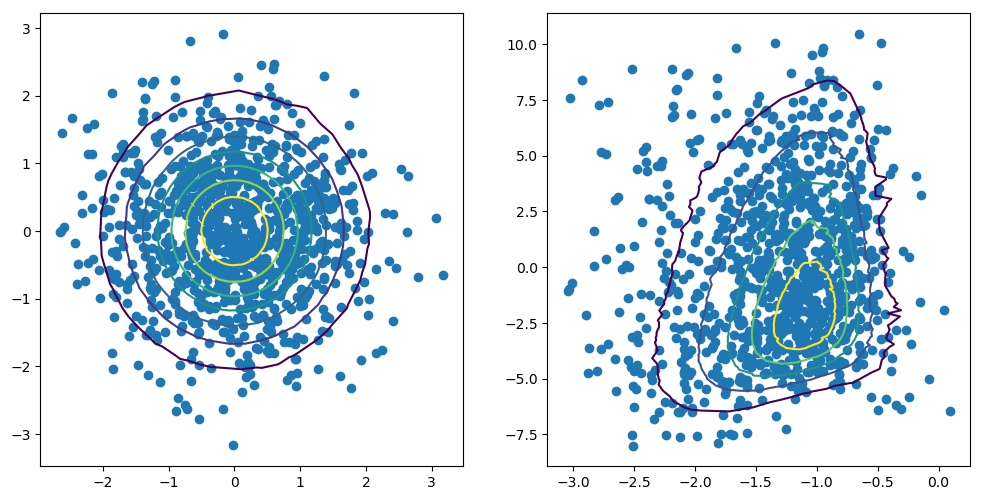

In [2]:
import numpy as np
import TransportMaps as TM
import TransportMaps.Distributions as DIST

nprocs = 3
dim = 2
order = 3
nsamps = 1000

# Start a pool of processes
mpi_pool = TM.get_mpi_pool()
mpi_pool.start(nprocs)

# Wrap everything in a try-finally to terminate the pool in case of any exception
try:
    # Instantiate the transport map with random coefficients
    T = TM.Default_IsotropicIntegratedExponentialTriangularTransportMap(dim, order, 'total')
    T.set_coeffs(np.random.randn(T.get_n_coeffs()))

    # Draw samples from N(0,1)
    d = DIST.StandardNormalDistribution(2)
    x = d.rvs(nsamps)

    # Push forward samples (using MPI!)
    scatter_tuple = (['x'],[x])
    y = TM.mpi_eval('evaluate', scatter_tuple=scatter_tuple, obj=T, mpi_pool=mpi_pool)
finally:
    mpi_pool.stop()

# Plot the original samples and the mapped samples
pfd = DIST.PushForwardTransportMapDistribution(T, d)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(121)
ax.scatter(x[:,0],x[:,1])
ax.tricontour(x[:,0],x[:,1],d.pdf(x))
ax = fig.add_subplot(122)
ax.scatter(y[:,0],y[:,1])
ax.tricontour(y[:,0],y[:,1],pfd.pdf(y))

## Standalone MPI

MPI jobs can be run on a personal machines or a clusters that does not require the action of intermediate queueing systems. These settings can be grouped into _standalone MPI_ configurations. The following section will describe how to write scripts in these situations. These guidelines will be valid also for writing scripts in [shared clusters](#MPI-on-shared-clusters) configurations, with the only addition that the user should call such script though the available queuing manager.

### Example 0: Minimization of the KL-divergence and sampling

Here we provide a full example on how to use the MPI functionalities of [TransportMaps](index.html) to approximate the Gumbel distribution as already described [here](example-gumbel-1d.html).

In [3]:
import TransportMaps as TM
import TransportMaps.Distributions as DIST

nprocs = 2

# Define target distribution
mu = 3.
beta = 4.
target_density = DIST.GumbelDistribution(mu,beta)

# Define base density
base_density = DIST.StandardNormalDistribution(1)

# Define approximating transport map
order = 5
tm_approx = TM.Default_IsotropicIntegratedExponentialTriangularTransportMap(1, order, 'full')

# Define approximating density
tm_density = DIST.PushForwardTransportMapDistribution(tm_approx, base_density)

# Start pool of processes
mpi_pool = TM.get_mpi_pool()
mpi_pool.start(nprocs)

# Solve and sample
try:
    qtype = 3      # Gauss quadrature
    qparams = [20] # Quadrature order
    reg = None     # No regularization
    tol = 1e-10    # Optimization tolerance
    ders = 1       # Use gradient and Hessian 
    log_entry_solve = tm_density.minimize_kl_divergence(
        target_density, qtype=qtype, qparams=qparams,
        regularization=reg, tol=tol, ders=ders,
        mpi_pool=mpi_pool) # Note the extra parameter mpi_pool!!
finally:
    mpi_pool.stop()

         Current function value: 1.420108
         Iterations: 40
         Function evaluations: 42
         Gradient evaluations: 41


### Background and design

The overall functioning of MPI in the [TransportMaps](index.html) module revolves around the following scheme:

![](Figures/flowchart.png)

The green boxes are the <font color="green">user-friendly</font> functionalities implemented in the TransportMaps module, the red boxes are <font color="red">intermediate</font> functionalities implemented in the module [mpi_map](https://pypi.python.org/pypi/mpi_map/), whereas the purple boxes are <font color="purple">low-level</font> functionalities implemented in the module [mpi4py](https://pypi.python.org/pypi/mpi4py) which interfaces with the MPI backend.

The two central tools for writing an MPI script in the `TransportMaps` framework are:
1. an instance of [MPI_Pool](http://mpi-map.readthedocs.io/en/latest/index.html#mpi_map.MPI_Pool), which keeps track of all the children processes
2. the method [mpi_eval()](api-TransportMaps.html#TransportMaps.mpi_eval), which submit jobs and handle the communication with the `MPI_pool`.

[TransportMaps](index.html) is designed to use MPI in a _star configuration_, where communication is only needed between the central node (a.k.a. _parent_) and the peripheral nodes (a.k.a. _children_).

![](./Figures/MPI-star-structure.png)

The parent node will hold a reference to the [MPI_Pool](http://mpi-map.readthedocs.io/en/latest/index.html#mpi_map.MPI_Pool) which will handle all its communication with the children. The [MPI_Pool](http://mpi-map.readthedocs.io/en/latest/index.html#mpi_map.MPI_Pool) is also in charge of dynamically creating the children via a process called [spawning](https://en.wikipedia.org/wiki/Message_Passing_Interface#Dynamic_process_management).

The following script *spawns* `n` children processes and then terminates them:

In [4]:
import TransportMaps as TM
n = 2 

# Instantiate the MPI handler
mpi_pool = TM.get_mpi_pool()
# Start two processes
mpi_pool.start(n)
# Terminate the processes
mpi_pool.stop()

This script can be simply run using 

$ python script.py

_Note_: the readers familiar with other ways of using MPI, must notice that there is no need to use the command `mpirun`. The dynamic allocation of processes allows the user to write MPI scripts which differ very little from the non-MPI ones.

Despite the [TransportMaps](index.html) hides all the MPI communication to the user, it is useful to know how the MPI evaluations work, in order to fully exploit the MPI functionalities. The three main MPI communication operations we use are:

* `broadcast`: send the same message to all the children
* `scatter`: send `n` different messages to the `n` children
* `gather`: collect `n` different messages from the `n` children

Given a function `f` and appropriate parameters, the method [mpi_eval()](api-TransportMaps.html#TransportMaps.mpi_eval) applies `f` to its inputs using the available children processes, using a sequence of `broadcast`, `scatter` and `gather` calls. We will present the functionalities of [mpi_eval()](api-TransportMaps.html#TransportMaps.mpi_eval) through some increasingly complex examples.

### Example 1: scatter and broadcast

In the following example, we consider the function

In [5]:
import numpy as np
def f(x, y):
    return x+y

where `x` is expected to be a chunk of a [numpy.ndarray](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.html) and `y` is an extra parameter.

In [6]:
import TransportMaps as TM

n = 2
x = np.random.randn(5)
y = 2.

# Instantiate the MPI handler
mpi_pool = TM.get_mpi_pool()
# Start two processes
mpi_pool.start(n)

try:
    # Arguments to be scattered:
    # First list contains the input names of the arguments
    # Second list contains the arguments in the same order
    scatter_tuple = (['x'],[x])
    
    # Arguments to be broadcasted:
    # First list contains the input names
    # Second list contains the arguments
    bcast_tuple = (['y'],[y])
    
    # Evaluate
    z = TM.mpi_eval(f, scatter_tuple=scatter_tuple, bcast_tuple=bcast_tuple, mpi_pool=mpi_pool)
finally:
    # Terminate the processes
    mpi_pool.stop()

print("x: %s" % str(x))
print("z: %s" % str(z))

x: [ 0.1027383   0.50022279 -1.6727281  -1.07878267 -0.35521337]
z: [ 2.1027383   2.50022279  0.3272719   0.92121733  1.64478663]


The evaluation step performed by [mpi_eval()](api-TransportMaps.html#TransportMaps.mpi_eval) performs the operations depicted in the following figure:

![](./Figures/mpi_eval-simple.png)

where the dashed lines indicate a process waiting on the next block, full lines indicate sequential steps, dot-ended lines show data transfer, and the green boxes show the <font color="green">memory content available to process `Pi`</font>. All the communication steps are syncronized.

### Example 2: distributed memory

In the following example we want to evaluate `niter` times the same function of the previous example on different input `x`.

In [7]:
import numpy as np
def f(x, y):
    return x+y

It makes sense then to store `y` in the distributed memory and not to broadcast it every time we need to evaluate `f`.

In [8]:
import TransportMaps as TM

nprocs = 2
niter = 2
y = 2.

# Function that sets parameters in the distributed memory
def set_y(y):
    return (None,y)

# Instantiate the MPI handler
mpi_pool = TM.get_mpi_pool()
# Start two processes
mpi_pool.start(nprocs)

try:
    # Set y in the distributed memory
    bcast_tuple = (['y'],[y])
    dmem_key_out_list = ['y']
    TM.mpi_eval(set_y, bcast_tuple=bcast_tuple, dmem_key_out_list=dmem_key_out_list, 
                mpi_pool=mpi_pool, concatenate=False)
    
    for i in range(niter):
        x = np.random.randn(5)
        print("it: %d - x: %s" % (i,str(x)))
        
        # Scatter argument
        scatter_tuple = (['x'],[x])
        # Arguments to identify the argument in the distributed memory
        dmem_key_in_list = ['y']  # Keyword used to store the value (same as dmem_key_out_list above)
        dmem_arg_in_list = ['y']  # Keyword identifying the argument in `f(x,y)`
        dmem_val_in_list = [None] # Parameter used only in case no mpi_pool has been started
        # Evaluate
        z = TM.mpi_eval(f, scatter_tuple=scatter_tuple, 
                        dmem_key_in_list=dmem_key_in_list,
                        dmem_arg_in_list=dmem_arg_in_list,
                        dmem_val_in_list=dmem_val_in_list,
                        mpi_pool=mpi_pool)
        print("it: %d - z: %s" % (i,str(z)))
finally:
    # Terminate the processes
    mpi_pool.stop()

it: 0 - x: [-1.30161791 -0.184273   -0.28962205 -0.04948687 -1.57852935]
it: 0 - z: [ 0.69838209  1.815727    1.71037795  1.95051313  0.42147065]
it: 1 - x: [-1.0863749  -0.87128219  2.12411264 -0.27763899 -0.21126548]
it: 1 - z: [ 0.9136251   1.12871781  4.12411264  1.72236101  1.78873452]


The following graph depicts the workflow of [mpi_eval()](api-TransportMaps.html#TransportMaps.mpi_eval) for this example, where the parameter `y` is stored in each of the children's memory and used in a following call.

![](./Figures/mpi_eval-distributed-memory.png)

### Example 3: functions with additional module dependencies

In some scenarios the funcion that one wants to evaluate may involve some extra modules, which need to be imported by the _children_ processes. In this example let us consider the function which given a set of points `x` evaluate the PDF of the distribution $N(0,1)$ at these points.

In [9]:
import scipy.stats as st
def f(x):
    return st.norm().pdf(x)

Despite having imported the `scipy.stats` module on the _parent_ process, the _children_ processes will have no definition of the object `st`. The following script circumvent this problem by telling the [MPI_Pool](http://mpi-map.readthedocs.io/en/latest/index.html#mpi_map.MPI_Pool) to import certain modules (note: the same result could be obtained using the argument `import_set` of [mpi_eval()](api-TransportMaps.html#TransportMaps.mpi_eval), but this import would hold only for the calls happening after [mpi_eval()](api-TransportMaps.html#TransportMaps.mpi_eval)).

In [10]:
import TransportMaps as TM

nprocs = 2
x = np.random.randn(5)

# Define the modules to be imported and their placeholder name
import_set = set([('scipy.stats','st')]) # import scipy.stats as st

# Instantiate the MPI handler
mpi_pool = TM.get_mpi_pool()
# Start two processes which import import_set modules
mpi_pool.start(nprocs, import_set=import_set)

try:
    scatter_tuple = (['x'],[x])
    z = TM.mpi_eval(f, scatter_tuple=scatter_tuple, mpi_pool=mpi_pool)
finally:
    # Terminate the processes
    mpi_pool.stop()

print("x: %s" % str(x))
print("z: %s" % str(z))

x: [-1.12696166  0.85828492  1.3512121  -1.15013032 -0.7778163 ]
z: [ 0.21140917  0.27602467  0.16012098  0.20590541  0.29480604]


### Example 4: map-reduce

In the following example we want to compute $\mathbb{E}[f(X)]$, where $f$ is defined by

In [11]:
def f(x):
    return x + 2

and the expectation is with respect to the random variable $X\sim\mathcal{N}(0,1)$. In practice we will compute a Monte Carlo estimation of $\mathbb{E}[f(X)]$ as:

\begin{equation}
\mathbb{E}[f(X)] \approx \sum_{i=1}^N f(x_i) w_i = \frac{1}{N} \sum_{i=1}^N f(x_i)
\end{equation}

Each of the function evaluations can clearly be done separately, thus using the MPI tools presented so far. 

One naive way of performing this task is to perform all the function evaluations and gather the resulting values $\{f(x_i)\}_{i=1}^N$ in the parent node, which will then perform the summation. This is clearly not an optimal approach. A better strategy would be to ask the _children_ processes to compute partial sums. In practice, if we have $m$ processes, the estimator can be rewritten as:

\begin{equation}
\mathbb{E}[f(X)] \approx \sum_{j=1}^m \frac{1}{N_j} \sum_{i=1}^{N_j} f(x_i)
\end{equation}

where the outer sum is parallelized and each process need only to perform $\sim N/m$ function evaluations. 
This approach is better than the naive one for several reasons:

* the _children_ processes are used more
* the _parent_ process will gather less data (communication is an important factor when one works with big objects)

The [mpi_map](https://pypi.python.org/pypi/mpi_map/) module provides a flexible way of defining new reduce operations, extending the class [ReduceObject](http://mpi-map.readthedocs.io/en/latest/index.html#mpi_map.ReduceObject). The [TransportMaps](index.html) module defines some default reduce operations, including the [ExpectationReduce](api-TransportMaps.html#TransportMaps.ExpectationReduce) which we need for this example.

In [12]:
import TransportMaps as TM

nprocs = 2
x = np.random.randn(1000)

# Instantiate the MPI handler
mpi_pool = TM.get_mpi_pool()
# Start two processes
mpi_pool.start(nprocs)

try:
    # Define the reduce object and its arguments
    w = np.ones(x.shape)/float(len(x)) # uniform weights to be used in the MC estimator
    reduce_obj = TM.ExpectationReduce()
    reduce_tuple = (['w'],[w])
    # Scatter arguments
    scatter_tuple = (['x'],[x])
    # Evaluate
    z = TM.mpi_eval(f, scatter_tuple=scatter_tuple, 
                    reduce_obj=reduce_obj, reduce_tuple=reduce_tuple,
                    mpi_pool=mpi_pool)
finally:
    # Terminate the processes
    mpi_pool.stop()

print("E[f(x)]: %s" % str(z))

E[f(x)]: 1.98047125065


## MPI on shared clusters (SLURM)

Many organization adopt shared [cluster](https://en.wikipedia.org/wiki/Computer_cluster) to provide their employees with exthensive computational resources. As for any shared resource, the usage of these cluster is regulated through some organization-wide policy, which is often enforced through a queuing system. Here we will show how to set up a script to be executed on a cluster which runs the queuing system [slurm](http://slurm.schedmd.com/).

We consider a setting where there are 2 nodes available with 8 cores each, and we solve the same problem presented in [Example 0](#Example-0:-Minimization-of-the-KL-divergence-and-sampling). The same script can be used in this setting, where we update the ``nprocs`` field to match the number of processors available:

In [13]:
nprocs = 16

We let this script be called `example-0.py`.

Next we need to write the slurm _submission script_ `submit.sh` with the following content

The script can then be run on the cluster with the command:

**Note**: The number of processes made available from slurm through the `submit.sh` script, must match the number of processes `nprocs` required in the python script `example-0.py`.